In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import json
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
def remove_outliers(group):
    # Calculate the 10th and 90th percentiles for the number of moves in this grade
    lower_bound = group['moves_length'].quantile(0.10)
    upper_bound = group['moves_length'].quantile(0.90)
    
    # Filter out the outliers
    filtered_group = group[(group['moves_length'] <= upper_bound)]
    return filtered_group

In [3]:
def parser(path):
    with open(path) as file:
        data = json.load(file)

    df = pd.json_normalize(data, record_path=['data'])
    return data, df

In [4]:
path = 'problems_2023_01_30/problems MoonBoard 2016 .json'

In [5]:
data, df = parser(path)

In [6]:
df = df[df['grade'] != '6B']

In [7]:
grade_mapping = {
    '6B+': 0, '6C': 1, '6C+': 1, '7A': 2, '7A+': 2,
    '7B': 3, '7B+': 3, '7C': 4, '7C+': 4, '8A': 5,
    '8A+': 5, '8B': 6, '8B+': 6
}

In [8]:
def encode_grades(df, grade_mapping):
    df['grade_encoded'] = df['grade'].apply(lambda x: grade_mapping.get(x, -1))
    return df

df_encoded = encode_grades(df, grade_mapping)

In [9]:
df_encoded['moves_length'] = df_encoded['moves'].apply(lambda x: len(x))

In [10]:
# df_encoded = df_encoded.groupby('grade_encoded', group_keys=False).apply(remove_outliers)

In [11]:
df_encoded['grade_encoded'].value_counts()

grade_encoded
0    19164
1    16533
2    14006
3     6116
4     3039
5      513
6      126
Name: count, dtype: int64

In [12]:
# df_encoded = df_encoded[df_encoded['grade_encoded'] != 6]

In [13]:
def description_to_index(description):
    col_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10}
    number_of_columns = 11
    
    col = col_dict[description[0].upper()]
    
    row = int(description[1:]) - 1
    
    return row * number_of_columns + col


In [14]:
def encode_moves(moves_list):
    vector = [0] * (18 * 11)
    for move_dict in moves_list:
        if 'description' in move_dict:
            move_description = move_dict['description']
            index = description_to_index(move_description)
            vector[index] = 1
    return vector

In [15]:
df_encoded['encoded_moves'] = df_encoded['moves'].apply(encode_moves)


---

In [16]:
train_df, test_df = train_test_split(df_encoded, test_size=0.2)

In [17]:
# train_df = train_df[train_df['repeats'] > 1]

In [18]:
X_train = torch.tensor(train_df['encoded_moves'].tolist(), dtype=torch.float32)
y_train = torch.tensor(train_df['grade_encoded'].tolist(), dtype=torch.long)
X_test = torch.tensor(test_df['encoded_moves'].tolist(), dtype=torch.float32)
y_test = torch.tensor(test_df['grade_encoded'].tolist(), dtype=torch.long)

In [19]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

class_counts = torch.bincount(y_train)
class_weights = 1. / class_counts.float()
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=1000, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [20]:
for inputs, labels in train_loader:
    print(labels)

tensor([2, 2, 0, 2, 5, 1, 0, 3, 3, 4, 2, 4, 2, 0, 5, 4, 6, 3, 0, 5, 3, 3, 6, 6,
        3, 4, 1, 5, 5, 4, 6, 2, 1, 4, 1, 4, 1, 5, 3, 5, 5, 1, 0, 1, 2, 4, 1, 4,
        0, 2, 2, 3, 0, 2, 2, 5, 1, 0, 2, 1, 2, 0, 6, 2, 0, 5, 6, 2, 3, 1, 5, 3,
        3, 5, 0, 0, 0, 0, 4, 4, 6, 4, 1, 3, 3, 2, 0, 2, 6, 1, 6, 3, 1, 3, 0, 2,
        4, 5, 4, 3, 5, 5, 5, 0, 2, 1, 1, 4, 4, 1, 4, 3, 2, 3, 0, 2, 6, 0, 0, 3,
        0, 5, 3, 5, 6, 5, 6, 6, 6, 1, 3, 6, 2, 4, 5, 0, 3, 4, 6, 0, 3, 0, 2, 6,
        5, 5, 3, 2, 3, 2, 6, 4, 2, 4, 6, 5, 2, 0, 5, 2, 6, 3, 4, 2, 3, 5, 1, 3,
        1, 1, 2, 4, 5, 3, 3, 0, 2, 4, 3, 3, 1, 0, 6, 4, 3, 5, 2, 2, 1, 1, 3, 5,
        5, 3, 4, 5, 3, 4, 4, 2, 1, 6, 1, 6, 6, 2, 6, 5, 6, 2, 4, 3, 6, 6, 1, 2,
        5, 4, 1, 4, 6, 5, 4, 0, 4, 6, 6, 2, 4, 0, 3, 1, 0, 3, 1, 6, 4, 6, 1, 0,
        2, 3, 6, 0, 2, 0, 4, 6, 1, 1, 0, 1, 4, 5, 0, 1, 5, 5, 6, 3, 1, 1, 4, 5,
        3, 6, 3, 3, 3, 4, 0, 4, 3, 2, 3, 4, 0, 4, 0, 6, 1, 3, 2, 4, 2, 3, 1, 0,
        0, 2, 4, 5, 0, 0, 4, 3, 4, 4, 5,

In [21]:
# #NO WEIGTHT
# X_tensor = torch.tensor(X, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.long)

# dataset = TensorDataset(X_tensor, y_tensor)

# class_counts = torch.bincount(y_tensor)
# class_weights = 1. / class_counts
# sample_weights = class_weights[y_tensor]

# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# indices = torch.randperm(len(dataset)).tolist()

# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size

# train_indices = indices[:train_size]
# test_indices = indices[train_size:]

# train_dataset = Subset(dataset, train_indices)
# test_dataset = Subset(dataset, test_indices)

# train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [22]:
# # WEIGHT
# X_tensor = torch.tensor(X, dtype=torch.float32)
# y_tensor = torch.tensor(y, dtype=torch.long)

# dataset = TensorDataset(X_tensor, y_tensor)

# # Calculate class weights
# class_counts = torch.bincount(y_tensor)
# class_weights = 1. / class_counts.float()
# sample_weights = class_weights[y_tensor]

# indices = torch.randperm(len(dataset)).tolist()
# train_size = int(0.8 * len(dataset))
# train_indices = indices[:train_size]
# test_indices = indices[train_size:]

# train_sample_weights = sample_weights[train_indices]

# train_sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

# train_dataset = Subset(dataset, train_indices)
# test_dataset = Subset(dataset, test_indices)

# train_loader = DataLoader(train_dataset, batch_size=500, sampler=train_sampler, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)


In [23]:
class ClimbNet(nn.Module):
    def __init__(self):
        super(ClimbNet, self).__init__()
        self.lin1 = nn.Linear(198, 500)
        self.bn1 = nn.BatchNorm1d(500)
        self.dropout1 = nn.Dropout(0.2)  # Adjusted dropout rate
        self.lin2 = nn.Linear(500, 250)
        self.bn2 = nn.BatchNorm1d(250)
        self.dropout2 = nn.Dropout(0.2)
        self.lin3 = nn.Linear(250, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.dropout3 = nn.Dropout(0.2)  # Added an extra layer
        self.lin4 = nn.Linear(100, 7)  # Adjusted final layer
        
    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.lin1(x))))
        x = self.dropout2(F.relu(self.bn2(self.lin2(x))))
        x = self.dropout3(F.relu(self.bn3(self.lin3(x))))
        x = self.lin4(x)
        return x

In [24]:
model = ClimbNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Save the model weights
torch.save(model.state_dict(), 'climbnet_weights.pth')

/Users/MaxSivolella/anaconda3/lib/python3.11/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


Epoch 1, Loss: 1.1166561841964722
Epoch 2, Loss: 0.9039875864982605
Epoch 3, Loss: 0.8276095986366272
Epoch 4, Loss: 0.7338694930076599
Epoch 5, Loss: 0.6928525567054749
Epoch 6, Loss: 0.6669468283653259
Epoch 7, Loss: 0.6493349671363831
Epoch 8, Loss: 0.7044340372085571
Epoch 9, Loss: 0.5982677340507507
Epoch 10, Loss: 0.6038914918899536
Epoch 11, Loss: 0.5799555778503418
Epoch 12, Loss: 0.6551644802093506
Epoch 13, Loss: 0.5526524186134338
Epoch 14, Loss: 0.5990065336227417
Epoch 15, Loss: 0.5813643932342529
Epoch 16, Loss: 0.5358412861824036
Epoch 17, Loss: 0.5662980079650879
Epoch 18, Loss: 0.5855941772460938
Epoch 19, Loss: 0.5172925591468811
Epoch 20, Loss: 0.5241988897323608
Epoch 21, Loss: 0.4482150375843048
Epoch 22, Loss: 0.5209409594535828
Epoch 23, Loss: 0.482345849275589
Epoch 24, Loss: 0.457453191280365
Epoch 25, Loss: 0.5327724814414978
Epoch 26, Loss: 0.49874672293663025
Epoch 27, Loss: 0.5529677867889404
Epoch 28, Loss: 0.4437461793422699
Epoch 29, Loss: 0.469167530536

In [25]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_loss = test_loss / len(test_loader.dataset)
accuracy = correct / total

print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Test Loss: 0.0014, Accuracy: 0.5385


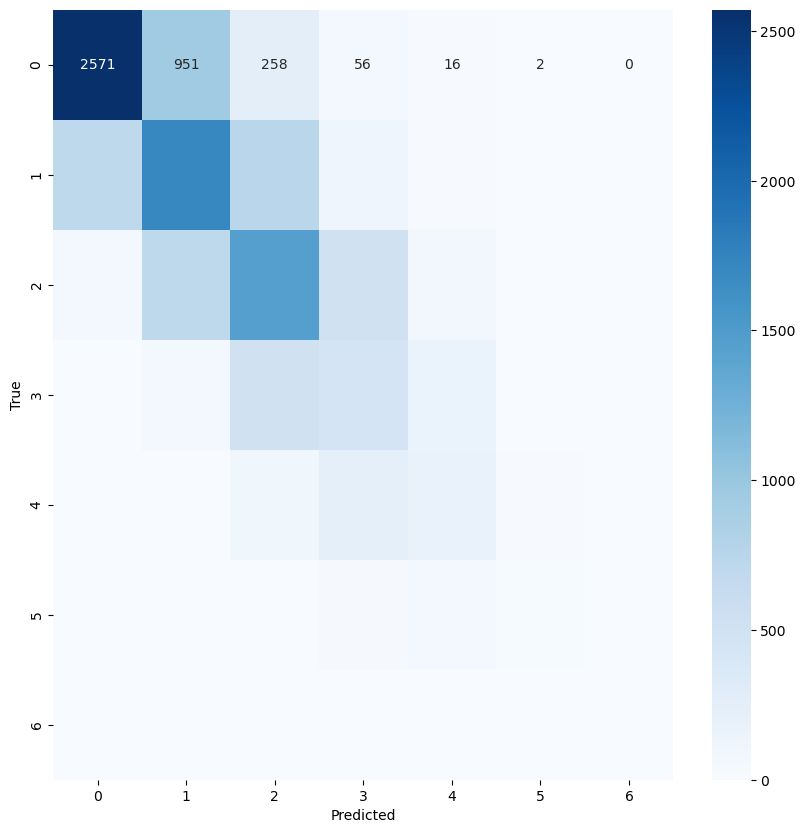

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
softmax = nn.Softmax(dim=1)

all_probabilities = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = softmax(outputs)
        all_probabilities.extend(probabilities.cpu().numpy())

In [28]:
top_k = 3
correct_topk = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, topk_predicted = outputs.topk(top_k, 1, True, True)
        correct_topk += topk_predicted.eq(labels.view(-1, 1).expand_as(topk_predicted)).sum().item()

accuracy_topk = correct_topk / total
print(f"Top-{top_k} accuracy: {accuracy_topk:.4f}")

Top-3 accuracy: 0.9343


In [29]:
model.eval()
all_preds = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        all_preds.append(probabilities.cpu().numpy())
        all_true_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_true_labels = np.concatenate(all_true_labels, axis=0)

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

n_classes = all_preds.shape[1]
classes = range(n_classes)

all_true_labels_bin = label_binarize(all_true_labels, classes=classes)

auroc = roc_auc_score(all_true_labels_bin, all_preds, multi_class='ovr')

print(f"Multi-class AUROC: {auroc:.4f}")

Multi-class AUROC: 0.8357


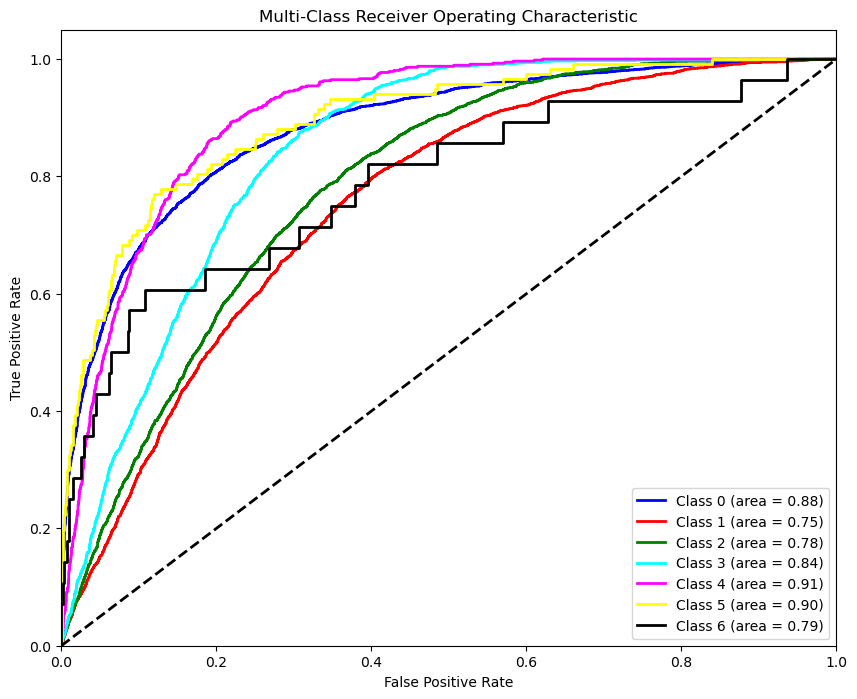

In [31]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

n_classes = all_preds.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_labels_bin[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
